# Face Mask Classification (part 2)
#### CHAPTER 13: _Adversarial Robustness_
##### From **[Interpretable Machine Learning with Python](https://www.packtpub.com/product/interpretable-machine-learning-with-python/9781800203907)** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

These are all already installed on Google Colab by default so install only if running elsewhere (and ***not already installed***):

In [ ]:
!pip install --upgrade numpy scikit-learn tensorflow matplotlib seaborn tqdm

Install these if running on Google Colab or ***not already installed***:

In [ ]:
!pip install --upgrade machine-learning-datasets
!pip install --upgrade adversarial-robustness-toolbox

### Loading the Libraries

In [1]:
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import machine_learning_datasets as mldatasets
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.certification.randomized_smoothing import TensorFlowV2RandomizedSmoothing
from art.utils import compute_accuracy

### Understanding and Preparing the Data

In [2]:
X_train, X_test, y_train, y_test =\
                                    mldatasets.load("maskedface-net_thumbs_sampled", prepare=True)
X_train, X_test = X_train / 255.0, X_test / 255.0
min_ = X_train.min()
max_ = X_train.max()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/maskedface-net_thumbs_sampled.zip downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled.zip
/Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled.zip uncompressed to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled
21000 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled folder


In [68]:
print('X_train dim:\t%s' % (X_train.shape,))
print('X_test dim:\t%s' % (X_test.shape,))
print('y_train dim:\t%s' % (y_train.shape,))
print('y_test dim:\t%s' % (y_test.shape,))
print('X_train min:\t%s' % (min_))
print('X_train max:\t%s' % (max_))
print('y_train labels:\t%s' % (np.unique(y_train)))

X_train dim:	(16800, 128, 128, 3)
X_test dim:	(4200, 128, 128, 3)
y_train dim:	(16800, 1)
y_test dim:	(4200, 1)
X_train min:	0.0
X_train max:	1.0
y_train labels:	['Correct' 'Incorrect' 'None']


In [5]:
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y_train)
labels_l = ohe.categories_[0].tolist()
print(labels_l)

['Correct', 'Incorrect', 'None']


In [3]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [4]:
sampl_md_idxs = np.random.choice(X_test.shape[0], 200, replace=False)
X_test_mdsample = X_test[sampl_md_idxs].astype(np.float32)
y_test_mdsample = y_test[sampl_md_idxs]

## Evaluating and Certifying Adversarial Robustness

### Certifying Robustness with Randomized Smoothing

In [129]:
nb_epochs = 10
batch_size = 128
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.CategoricalCrossentropy()
nb_classes = len(np.unique(y_train))
sample_size = 100

X_train, X_test_mdsample = X_train.astype(np.float32), X_test_mdsample.astype(np.float32)
y_train_ohe = ohe.transform(y_train).astype(np.float32)
y_test_mdsample_ohe = ohe.transform(y_test_mdsample).astype(np.float32)

In [204]:
def get_model(input_shape, min_, max_):
    test_model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(768, activation='relu'),
        Dropout(0.35),
        Dense(3, activation='softmax')
    ])
    
    return test_model

In [133]:
def train_step(model, images, labels):        
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [134]:
def train_rs_classifier(X_train, y_train, nb_epochs, batch_size, min_, max_,\
                        nb_classes, sample_size, loss_object, train_step, sigma=0, sigma_cert=0.5,\
                        alpha=0.001):
    
    input_shape = X_train.shape[1:]
    if sigma > 0:
        rs_classifier = TensorFlowV2RandomizedSmoothing(model=get_model(input_shape, min_, max_),\
                                                        input_shape=input_shape,\
                                                        clip_values=(min_, max_),\
                                                        nb_classes=nb_classes,\
                                                        sample_size=sample_size,\
                                                        loss_object=loss_object,\
                                                        train_step=train_step,\
                                                        scale=sigma, alpha=alpha,\
                                                        channels_first=False)
        
        rs_classifier.fit(X_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size)
        
        return rs_classifier
    else:
        classifier = TensorFlowV2Classifier(model=get_model(input_shape, min_, max_),\
                                                input_shape=input_shape,\
                                                clip_values=(min_, max_),\
                                                nb_classes=nb_classes,\
                                                loss_object=loss_object,\
                                                train_step=train_step,\
                                                channels_first=False)
        
        classifier.fit(X_train, y_train, nb_epochs=nb_epochs, batch_size=batch_size)
        
        rs_classifier = TensorFlowV2RandomizedSmoothing(model=classifier.model,\
                                                        input_shape=input_shape,\
                                                        clip_values=(min_, max_),\
                                                        nb_classes=nb_classes,\
                                                        sample_size=sample_size,\
                                                        loss_object=loss_object,\
                                                        train_step=train_step,\
                                                        scale=sigma_cert, alpha=alpha,\
                                                        channels_first=False)
        return classifier, rs_classifier

In [149]:
sigma_0 = 0
classifier_0, rs_classifier_0 = train_rs_classifier(X_train, y_train_ohe, nb_epochs,\
                                                    batch_size, min_, max_, nb_classes,\
                                                    sample_size, loss_object, train_step,\
                                                    sigma_0) 

sigma_1 = 0.25
rs_classifier_1 = train_rs_classifier(X_train, y_train_ohe, nb_epochs, batch_size,\
                                      min_, max_, nb_classes, sample_size, loss_object,\
                                      train_step, sigma_1)

sigma_2 = 0.5
rs_classifier_2 = train_rs_classifier(X_train, y_train_ohe, nb_epochs, batch_size,\
                                      min_, max_, nb_classes, sample_size, loss_object,\
                                      train_step, sigma_2)

CPU times: user 1h 36min 30s, sys: 4min 26s, total: 1h 40min 57s
Wall time: 12min 33s


In [150]:
y_preds_0 = classifier_0.predict(X_test_mdsample)
y_preds_rs_1 = rs_classifier_1.predict(X_test_mdsample)
y_preds_rs_2 = rs_classifier_2.predict(X_test_mdsample)

Randomized smoothing: 100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


In [198]:
acc_0, cov_0 = compute_accuracy(y_preds_0, y_test_mdsample_ohe)
acc_rs_1, cov_rs_1 = compute_accuracy(y_preds_rs_1, y_test_mdsample_ohe)
acc_rs_2, cov_rs_2 = compute_accuracy(y_preds_rs_2, y_test_mdsample_ohe)

print("Original Classifier")
print("\tAccuracy: %.2f%%\tCoverage: %.2f%%" % (acc_0*100, cov_0*100))

print("\nSmoothed Classifier (σ=%.2f)" % (sigma_1))
print("\tAccuracy: %.2f%%\tCoverage: %.2f%%" % (acc_rs_1*100, cov_rs_1*100))

print("\nSmoothed Classifier (σ=%.2f)" % (sigma_2))
print("\tAccuracy: %.2f%%\tCoverage: %.2f%%" % (acc_rs_2*100, cov_rs_2*100))

Original Classifier
	Accuracy: 99.50%	Coverage: 100.00%

Smoothed Classifier (σ=0.25)
	Accuracy: 100.00%	Coverage: 99.50%

Smoothed Classifier (σ=0.50)
	Accuracy: 98.99%	Coverage: 99.50%


In [168]:
%%time
predictions_0, radiuses_0 = rs_classifier_0.certify(X_test_mdsample, n=500)
predictions_1, radiuses_1 = rs_classifier_1.certify(X_test_mdsample, n=500)
predictions_2, radiuses_2 = rs_classifier_2.certify(X_test_mdsample, n=500)

CPU times: user 1h 16min 3s, sys: 8min 31s, total: 1h 24min 35s
Wall time: 20min 52s


In [178]:
def calc_cert_accuracy(radius_list, predictions, radiuses, y_test):
    
    cert_accuracy = []
    nb_certs = len(radiuses)
    
    for r in radius_list:
        r_idx = np.where(radiuses >= r)[0]
        y_test_subset = y_test[r_idx]
        cert_accuracy_r = np.sum(predictions[r_idx] == np.argmax(y_test_subset, axis=1)) / nb_certs
        cert_accuracy.append(cert_accuracy_r)
        
    return cert_accuracy

In [186]:
radius_list = np.linspace(0, 1.5, 151)
cert_accuracy_0 = calc_cert_accuracy(radius_list, predictions_0,\
                                     radiuses_0, y_test_mdsample_ohe)
cert_accuracy_1 = calc_cert_accuracy(radius_list, predictions_1,\
                                     radiuses_1, y_test_mdsample_ohe)
cert_accuracy_2 = calc_cert_accuracy(radius_list, predictions_2,\
                                     radiuses_2, y_test_mdsample_ohe)

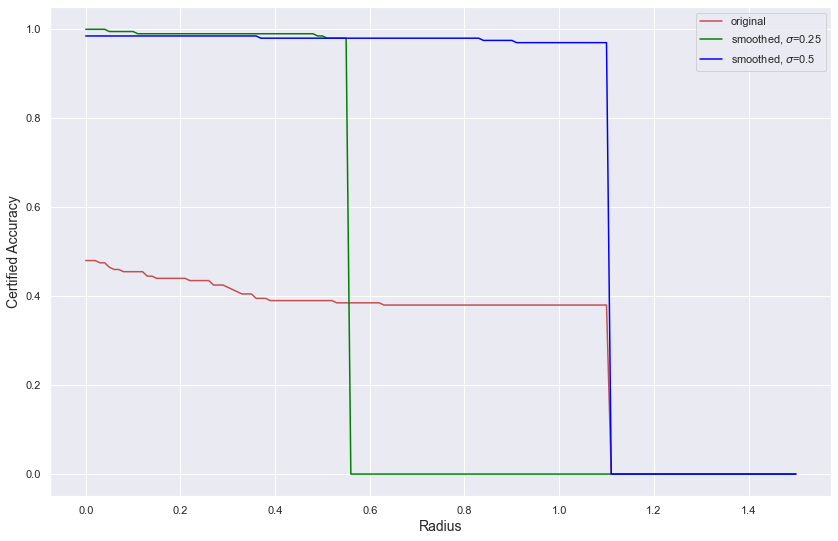

In [203]:
plt.figure(figsize=(14,9))
plt.plot(radius_list, cert_accuracy_0, 'r-', label='original')
plt.plot(radius_list, cert_accuracy_1,\
         '-', color='green', label='smoothed, $\sigma$=' + str(sigma_1))
plt.plot(radius_list, cert_accuracy_2,\
         '-', color='blue', label='smoothed, $\sigma$=' + str(sigma_2))
plt.xlabel('Radius', fontsize=14)
plt.ylabel('Certified Accuracy', fontsize=14)
plt.legend()
plt.show()